# IMDB Sentiment Analysis

**By Neuromatch Academy**

__Content creators:__  Mahdi Anvari, Hossein Ghermezcheshme, Sujal Awasthi, Harshil Shah

__Production editors:__ Mahdi Anvari

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import re
import torch
import torchtext
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Loading dataset

In [3]:
# Import the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/IMDBdataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
texts = df['review'].tolist()
labels = df['sentiment'].tolist()

**Preprocessing steps**

In [5]:
# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    return text

# Tokenization function
def tokenize(text):
    return word_tokenize(text)

# Stop words removal function
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Stemming function
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

# Lemmatization function
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess(text):
    text = clean_text(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return ' '.join(tokens)

def preprocess_and_tokenize(text):
    text = clean_text(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return tokens


In [6]:
df['cleaned_review'] = df['review'].apply(preprocess)
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


Lets make an example

In [8]:
sample_text = "I loved this movie! It was amazing, the acting was great and the plot was very exciting."
print(sample_text)
print(preprocess(sample_text))
print(preprocess_and_tokenize(sample_text))

I loved this movie! It was amazing, the acting was great and the plot was very exciting.
loved movie amazing acting great plot exciting
['loved', 'movie', 'amazing', 'acting', 'great', 'plot', 'exciting']


In [9]:
preprocessed_tokens = [preprocess_and_tokenize(text) for text in texts]

Building vocabulary

In [10]:
# Build vocabulary from the tokenized texts
from collections import Counter
def yield_tokens(data_iter):
    for tokens in data_iter:
        yield tokens

vocab = build_vocab_from_iterator(yield_tokens(preprocessed_tokens), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [11]:
words = Counter()
for s in preprocessed_tokens:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_nums = list(words.values())
sorted_words.sort(key=lambda w: words[w], reverse=True)
sorted_nums.sort(reverse=True)
print(f"Number of different reviews in our dataset: {len(preprocessed_tokens)}")
print(f"Number of different tokens in our dataset: {len(sorted_words)}")
print("Top 100 tokens and their frequencies:")
print(sorted_words[:100])
print(sorted_nums[:100])

Number of different reviews in our dataset: 50000
Number of different tokens in our dataset: 203664
Top 100 tokens and their frequencies:
['movie', 'film', 'one', 'like', 'time', 'good', 'character', 'get', 'even', 'story', 'would', 'make', 'see', 'really', 'scene', 'much', 'well', 'people', 'great', 'bad', 'also', 'show', 'first', 'dont', 'way', 'thing', 'made', 'could', 'think', 'life', 'go', 'know', 'watch', 'love', 'many', 'seen', 'actor', 'two', 'plot', 'say', 'never', 'look', 'acting', 'end', 'little', 'best', 'year', 'ever', 'better', 'take', 'man', 'come', 'still', 'work', 'part', 'find', 'something', 'want', 'give', 'lot', 'back', 'director', 'im', 'real', 'guy', 'watching', 'doesnt', 'performance', 'didnt', 'play', 'woman', 'actually', 'though', 'funny', 'another', 'nothing', 'going', 'role', 'u', 'new', 'old', 'every', 'girl', 'cant', 'point', 'cast', 'world', 'fact', 'thats', 'quite', 'day', 'got', 'pretty', 'feel', 'minute', 'thought', 'seems', 'around', 'young', 'comedy']

In [12]:
print(sum(sorted_nums[:100]))
print(sum(sorted_nums))
print(sum(sorted_nums[:100])/sum(sorted_nums))

1476813
5923292
0.24932301159557896


interesting!

In [13]:
print(sorted_nums[sorted_words.index("deep")])
print(sorted_nums[sorted_words.index("learning")])

1345
327


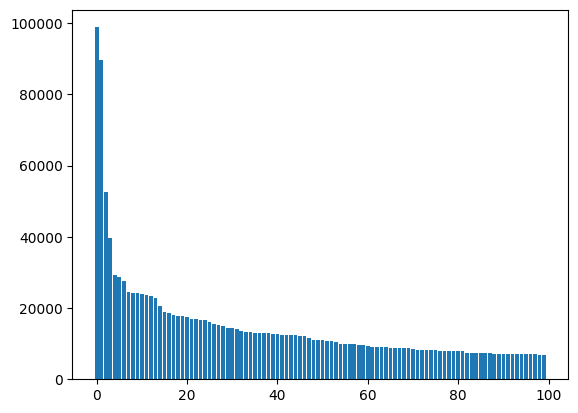

In [14]:
import matplotlib.pyplot as plt
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

Split the dataset

In [7]:
from sklearn.model_selection import train_test_split

# Split the data
X_train_txt, X_test_txt, Y_train, Y_test = train_test_split((df['cleaned_review']), df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
, test_size=0.5, random_state=42)

Now, lets vectorize the samples

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Fit and transform the cleaned reviews
X_train = vectorizer.fit_transform(X_train_txt).toarray()
X_test = vectorizer.transform(X_test_txt).toarray()

In [10]:
def check_nonzero_features(x):
  nonzero = x[x != 0]
  print("Number of nonzero features:" , len(nonzero))
  print((nonzero))
  # You can also get the index of nonzero features
  # print([index for index, value in enumerate(o != 0) if value])

In [11]:
print(check_nonzero_features(X_train[0]))

Number of nonzero features: 135
[0.08308818 0.04954787 0.09966081 0.15298001 0.03016194 0.0441028
 0.04114457 0.0993238  0.03100172 0.16672422 0.0500792  0.04819476
 0.07609498 0.09340828 0.10378096 0.05355693 0.06496041 0.12017865
 0.08437068 0.0884021  0.06264701 0.04697297 0.20756193 0.06562026
 0.07594037 0.03092596 0.06370697 0.20250485 0.06984642 0.03951615
 0.06942714 0.04905622 0.08120401 0.05023807 0.05603505 0.06828883
 0.07042808 0.08947972 0.1785134  0.08132123 0.04280841 0.03326436
 0.05714294 0.08005111 0.19306225 0.05980858 0.0437039  0.05325442
 0.03914241 0.0637653  0.08167956 0.03203274 0.09280815 0.04407826
 0.16728427 0.10828506 0.13270489 0.0484436  0.06090108 0.0787713
 0.06179373 0.18743884 0.1553338  0.03313255 0.02241406 0.2036772
 0.04434458 0.05043952 0.09821368 0.05497301 0.06984642 0.08947972
 0.08350134 0.0729636  0.08970676 0.03795311 0.11530888 0.0492395
 0.0198199  0.09867193 0.0635623  0.0487862  0.06115992 0.03304544
 0.06139994 0.04556621 0.04778516 

In [12]:
del X_train_txt
del X_test_txt

In [13]:
import gc
gc.collect()

0

# Implementation

Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(solver='saga')
LR_model.fit(X_train, Y_train)

LogisticRegression(solver='saga')

In [15]:
from sklearn.metrics import classification_report, accuracy_score
Y_pred_LR = LR_model.predict(X_test)
print(classification_report(Y_test, Y_pred_LR))
LR_acc = accuracy_score(Y_test , Y_pred_LR)
print(LR_acc)

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     12483
           1       0.87      0.90      0.89     12517

    accuracy                           0.88     25000
   macro avg       0.89      0.88      0.88     25000
weighted avg       0.89      0.88      0.88     25000

0.88492


Multi Layer Perceptron

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

MLP_model = Sequential()
MLP_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
MLP_model.add(Dropout(0.5))
MLP_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
MLP_model.add(Dropout(0.2))
MLP_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
MLP_model.add(Dense(1, activation='sigmoid'))

MLP_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.004),
              metrics=['accuracy'])

history = MLP_model.fit(X_train, Y_train,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.7711 - loss: 0.7425 - val_accuracy: 0.8588 - val_loss: 0.7699
Epoch 2/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.8608 - loss: 0.7778 - val_accuracy: 0.8634 - val_loss: 0.7666
Epoch 3/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8573 - loss: 0.7883 - val_accuracy: 0.8548 - val_loss: 0.7829
Epoch 4/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8658 - loss: 0.7720 - val_accuracy: 0.8604 - val_loss: 0.7483
Epoch 5/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8661 - loss: 0.7628 - val_accuracy: 0.8590 - val_loss: 0.7468
Epoch 6/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8679 - loss: 0.7343 - val_accuracy: 0.8626 - val_loss: 0.7171
Epoch 7/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8648 - loss: 0.7313 - val_accuracy: 0.8426 - val_loss: 0.7541


In [17]:
test_loss, test_accuracy = MLP_model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8420


Convolutional Neural Network

In [18]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Reshape X_train to fit the input shape of Conv1D
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

CNN_model = Sequential()
CNN_model.add(Conv1D(32, 5, activation='relu', input_shape=(10000, 1)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Conv1D(64, 5, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(1, activation='sigmoid'))
CNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
CNN_model.fit(X_train_cnn, Y_train, epochs=2, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.7692 - loss: 0.4644 - val_accuracy: 0.8642 - val_loss: 0.3086
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 653s 997ms/step - accuracy: 0.8977 - loss: 0.2492 - val_accuracy: 0.8734 - val_loss: 0.2980


In [19]:
# Evaluate the model
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

loss, accuracy = CNN_model.evaluate(X_test_cnn, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.4f}')

782/782 - 128s - 164ms/step - accuracy: 0.8721 - loss: 0.3045
Test Accuracy: 0.8721


Recurrent Neural Nrtwork

In [20]:
# Reshape the data to have time steps and features per time step
sequence_length = 1
num_features = 10000

X_train_RNN = X_train.reshape((25000, sequence_length, num_features))
X_test_RNN = X_test.reshape((25000, sequence_length, num_features))

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

RNN_model = Sequential()
RNN_model.add(SimpleRNN(400, input_shape=(1, 10000), return_sequences=False))
RNN_model.add(Dense(1, activation='sigmoid'))
RNN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
RNN_model.fit(X_train_RNN, Y_train, epochs=4, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - accuracy: 0.7467 - loss: 0.6272 - val_accuracy: 0.8682 - val_loss: 0.4099
Epoch 2/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8939 - loss: 0.3503 - val_accuracy: 0.8850 - val_loss: 0.3005
Epoch 3/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9192 - loss: 0.2457 - val_accuracy: 0.8904 - val_loss: 0.2714
Epoch 4/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9348 - loss: 0.1971 - val_accuracy: 0.8902 - val_loss: 0.2667


In [21]:
loss, accuracy = RNN_model.evaluate(X_test_RNN, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.4f}')

782/782 - 8s - 11ms/step - accuracy: 0.8906 - loss: 0.2647
Test Accuracy: 0.8906


Long Short-Term Memory

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

sequence_length = 1
num_features = 10000

X_train_LSTM = X_train.reshape((25000, sequence_length, num_features))
X_test_LSTM = X_test.reshape((25000, sequence_length, num_features))

LSTM_model = Sequential()
LSTM_model.add(LSTM(300, input_shape=(sequence_length, num_features), return_sequences=False))
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_model.fit(X_train_LSTM, Y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 188s 295ms/step - accuracy: 0.7962 - loss: 0.4936 - val_accuracy: 0.8880 - val_loss: 0.2691
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 209s 307ms/step - accuracy: 0.9313 - loss: 0.1850 - val_accuracy: 0.8810 - val_loss: 0.2994
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 297ms/step - accuracy: 0.9585 - loss: 0.1228 - val_accuracy: 0.8682 - val_loss: 0.3585
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 304ms/step - accuracy: 0.9723 - loss: 0.0853 - val_accuracy: 0.8584 - val_loss: 0.4466
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 190s 304ms/step - accuracy: 0.9820 - loss: 0.0627 - val_accuracy: 0.8548 - val_loss: 0.5373


In [23]:
loss, accuracy = LSTM_model.evaluate(X_test_LSTM, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.4f}')

782/782 - 21s - 27ms/step - accuracy: 0.8598 - loss: 0.5026
Test Accuracy: 0.8598


BERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
def analyze_sentiment(review):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    labels = ["negative", "positive"]
    predicted_label = labels[predicted_class]
    return predicted_label

In [ ]:
sample_data = df.sample(5000)
y_pred = sample_data['review'].apply(analyze_sentiment)
y = sample_data['sentiment']
accuracy = (y_pred == y).mean()
print("Average Accuracy by BERT uncased model:", accuracy)


Average Accuracy by BERT uncased model: 0.895


Comparison

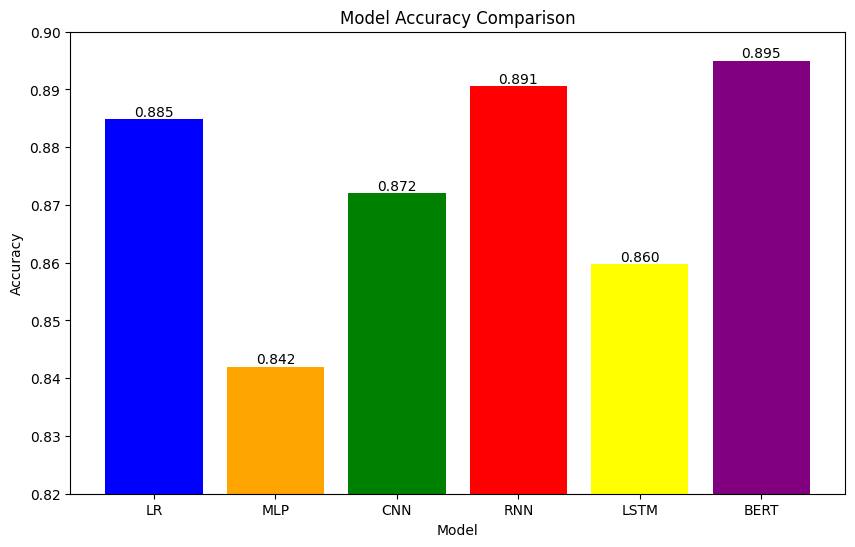

In [25]:
import matplotlib.pyplot as plt
data = {
    'Model': ['LR' , 'MLP', 'CNN' , 'RNN' , 'LSTM' , 'BERT'],
    'Accuracy': [0.88492, 0.8420, 0.8721, 0.8906, 0.8598, 0.8950]
}

# Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(data['Model'], data['Accuracy'], color=['blue' , 'orange' , 'green' , 'red' , 'yellow' , 'purple'])
for index, value in enumerate(data['Accuracy']):
    plt.text(index, value + 0.0005, f'{value:.3f}', ha='center')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.82, 0.90)
plt.show()